In [ ]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

for density 
* generate lenstronomy lens at a given pixel density
* start timer
* convert that to pandeia input
* run pandeia
* save figure
* stop time
* record time

In [ ]:
import sys
import os
import json

from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import numpy as np
from astropy.wcs import WCS
from astropy.table import Table
import astropy.wcs.utils

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import get_telescope_config, get_instrument_config, build_default_calc, build_default_source
from pandeia.engine.io_utils import read_json, write_json

import math
import time

from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()

from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.psf import PSF

  0%|          | 0/5 [00:00<?, ?it/s]

Converting to point sources...


45it [00:10,  4.29it/s]


Point source conversion complete
Performing Pandeia calculation...


Pandeia calculation complete


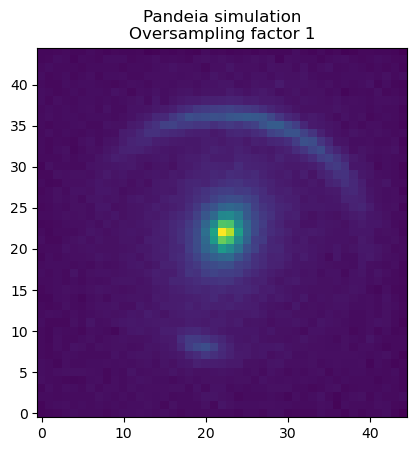

 20%|██        | 1/5 [03:12<12:48, 192.13s/it]

Converting to point sources...


135it [01:30,  1.48it/s]


Point source conversion complete
Performing Pandeia calculation...
Pandeia calculation complete


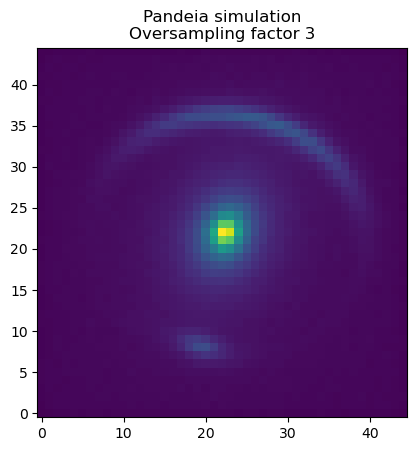

 40%|████      | 2/5 [33:17<57:03, 1141.07s/it]

Converting to point sources...


225it [04:32,  1.21s/it]


Point source conversion complete
Performing Pandeia calculation...
Pandeia calculation complete


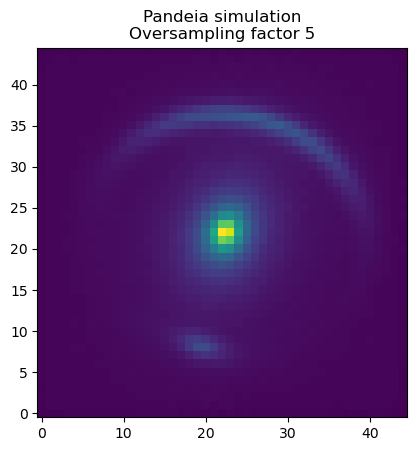

 60%|██████    | 3/5 [1:59:19<1:39:14, 2977.05s/it]

Converting to point sources...


315it [08:58,  1.71s/it]


Point source conversion complete
Performing Pandeia calculation...
Pandeia calculation complete


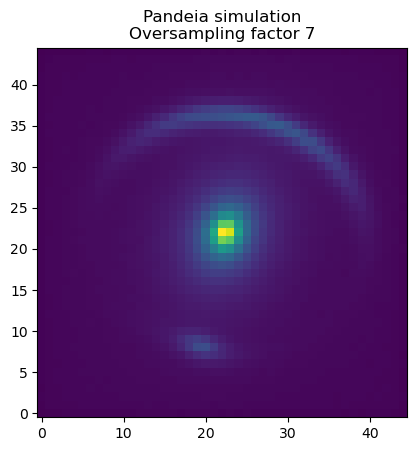

 80%|████████  | 4/5 [4:54:39<1:39:14, 5954.84s/it]

Converting to point sources...


405it [15:58,  2.37s/it]


Point source conversion complete
Performing Pandeia calculation...
Pandeia calculation complete


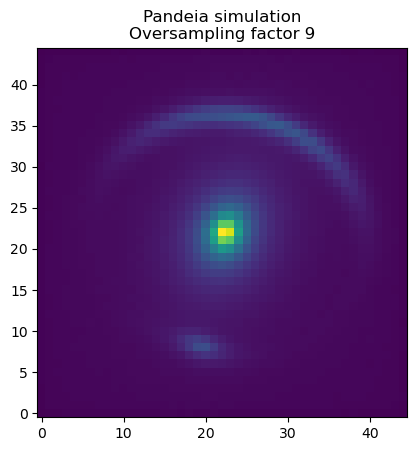

100%|██████████| 5/5 [9:27:47<00:00, 6813.59s/it]  


<Figure size 640x480 with 0 Axes>

In [16]:
oversample_factor_list = [1, 3, 5, 7, 9]
execution_time = []

# mass model
lens_model_list = ['SIE', 'SHEAR']
kwargs_spemd = {'theta_E': 1.7, 'e1': 0.07, 'e2': -0.03, 'center_x': 0.05, 'center_y': -0.25}
kwargs_shear = {'gamma1': 0.1, 'gamma2': -0.05}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list)

# light model
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic_lens = {'amp': 10, 'R_sersic': 0.6, 'n_sersic': 2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.05, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(lens_light_model_list)

# source model
source_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic = {'amp': 10, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}
kwargs_source_light = [kwargs_sersic]
source_model_class = LightModel(source_model_list)

kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'source_light_model_list': source_model_list}

kwargs_psf = {'psf_type': 'NONE'}
psf_class = PSF(**kwargs_psf)

kwargs_numerics = {'supersampling_factor': 4,
                'supersampling_convolution': False}

for oversample_factor in tqdm(oversample_factor_list):
    side = 5  # arcseconds
    num_pix = 45 * oversample_factor
    delta_pix = side / num_pix  # size of pixel in angular coordinates

    ra_at_xy_0, dec_at_xy_0 = -delta_pix * math.ceil(num_pix / 2), -delta_pix * math.ceil(num_pix / 2) # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
    transform_pix2angle = np.array([[1, 0], [0, 1]]) * delta_pix  # linear translation matrix of a shift in pixel in a shift in coordinates

    kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                    'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                    'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                    'transform_pix2angle': transform_pix2angle}
    pixel_grid = PixelGrid(**kwargs_pixel)

    imageModel = ImageModel(data_class=pixel_grid,
                            psf_class=psf_class,
                            lens_model_class=lens_model_class,
                            source_model_class=source_model_class,
                            lens_light_model_class=lens_light_model_class,
                            kwargs_numerics=kwargs_numerics)

    image = imageModel.image(kwargs_lens=kwargs_lens,
                            kwargs_source=kwargs_source_light,
                            kwargs_lens_light=kwargs_lens_light)

    plt.imshow(image)
    plt.title('Lenstronomy model\nOversampling factor ' + str(oversample_factor))
    plt.savefig(os.path.join('figures', 'pixel_density_test', 'model_' + str(oversample_factor) + '.png'))
    plt.close()

    np.save(os.path.join('arrays', 'model_' + str(oversample_factor)), image)

    # start timer
    start = time.time()

    calc = build_default_calc('roman','wfi','imaging')

    # scene size settings
    calc['configuration']['dynamic_scene'] = True
    calc['configuration']['max_scene_size'] = 5

    # change filter
    calc['configuration']['instrument']['filter'] = 'f106'

    # normalize (np.interp for now)
    max = np.max(image)
    min = np.min(image)

    image = np.interp(image, (min, max), (0.00001, 0.001))

    i = 0

    print('Converting to point sources...')
    for row_number, row in tqdm(enumerate(image)):
        for item_number, item in enumerate(row):
            if i != 0:
                calc['scene'].append(build_default_source(geometry="point"))
            calc['scene'][i]['position']['x_offset'] = (item_number * (1 / 9) * (1 / oversample_factor)) + ra_at_xy_0 # arcsec
            calc['scene'][i]['position']['y_offset'] = (row_number * (1 / 9) * (1 / oversample_factor)) + dec_at_xy_0 # arcsec
            calc['scene'][i]['spectrum']['normalization']['norm_flux'] = item

            i += 1
    print('Point source conversion complete')

    print('Performing Pandeia calculation...')
    results = perform_calculation(calc)
    print('Pandeia calculation complete')

    # stop timer
    stop = time.time()
    execution_time.append(stop - start)

    detector = results['2d']['detector']

    # TODO TEMP! flip image
    detector = np.flipud(detector)
    # detector = np.fliplr(detector)

    plt.imshow(detector)
    plt.title('Pandeia simulation\nOversampling factor ' + str(oversample_factor))
    plt.show()
    plt.savefig(os.path.join('figures', 'pixel_density_test', 'pandeia_' + str(oversample_factor) + '.png'))

    # save this numpy array
    np.save('detector_' + str(oversample_factor), detector)

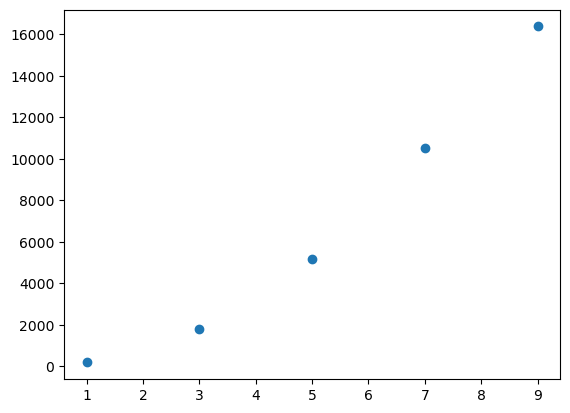

In [17]:
plt.scatter(oversample_factor_list, execution_time)
plt.show()

In [1]:
np.save('oversample_factor_list', oversample_factor_list)

NameError: name 'np' is not defined

# TODO residuals